In [1]:
import matplotlib.pyplot as plt
import numpy as np
from image_generation import generate_test_image, mycomputeColor, mycolorwheel
from conjugate_gradient import cg_main, OF_cg
from multigrid import multigrid_main, V_cycle
from preprocessing import calculate_image_derivatives, preprocess_image, get_rhs
import numerical_tests as nt

# Theoretical questions

The system (5) can be written as a problem on the form $Ax=b$, equivalently

$$
\begin{bmatrix}
D_{xx} + \lambda A_{1,1} & D_{xy} \\
D_{xy} & D_{2,2} + \lambda A_{2,2}
\end{bmatrix}
\begin{bmatrix}
u \\
v
\end{bmatrix}
=
b.
$$

All matrices and vectors are of dimensions

$$
D_{xx},\, D_{xy},\, D_{yy},\, A_{1,1}, A_{2,2} \in \mathbb{R}^{(m n) \times (m n)}, \qquad
u,\, v \in \mathbb{R}^{m n}, \qquad
b \in \mathbb{R}^{2 m n}.
$$ 

Rhe diagonal matrices are

$$
(D_{xx})_{i,j} =
\begin{cases}
0, & i \ne j, \\[6pt]
(I_x)_{i,i}^2, & i = j,
\end{cases}
\qquad\text{where}\qquad
(I_x)_{i,i}
= \tfrac{1}{2} \Big( (I_0 - I_1)_{i+1,\,i} - (I_0 - I_1)_{i,\,i} \Big).
$$

$$
(D_{yy})_{i,j} =
\begin{cases}
0, & i \ne j, \\[6pt]
(I_y)_{i,i}^2, & i = j,
\end{cases}
\qquad\text{where}\qquad
(I_y)_{i,i}
= \tfrac{1}{2} \Big( (I_0 - I_1)_{i,\,i+1} - (I_0 - I_1)_{i,\,i} \Big).
$$


$$
(D_{xy})_{i,j} =
\begin{cases}
0, & i \ne j, \\[6pt]
(I_x)_{i,i}\,(I_y)_{i,i}, & i = j,
\end{cases}
\qquad\text{where}\qquad
\begin{aligned}
(I_x)_{i,i} &= \tfrac{1}{2} \Big( (I_0 - I_1)_{i+1,\,i} - (I_0 - I_1)_{i,\,i} \Big), \\[4pt]
(I_y)_{i,i} &= \tfrac{1}{2} \Big( (I_0 - I_1)_{i,\,i+1} - (I_0 - I_1)_{i,\,i} \Big).
\end{aligned}
$$

Depending on what boundary condition we use we get two slightly different laplace discretizations. For Dirichlet B.C we get

$$
(A_{1,1}^{dir})_{ij} = (A_{2,2}^{dir})_{ij} =
\begin{cases}
4, & \text{if } i=j,\\
-1, & \text{if } |i-j|=1,\\
-1, & \text{if } |i-j|=m,\\
0, & \text{otherwise.}
\end{cases}
$$

$$
A_{1,1}^{dir} = A_{2,2}^{dir} = 
\begin{bmatrix}
4 & -1 &        &        & \cdots &        & -1     &        &        \\
-1& 4  & -1     &        &        & \cdots &        & -1     &        \\
   & -1 & 4     & -1     &        &        & \cdots &        & \ddots \\
   &    & \ddots& \ddots & \ddots &        &        &        &        \\
\vdots&  &       & -1     & 4     & -1     &        &        &        \\
      & \vdots  &        &        & -1     & 4      & -1     &        &        \\
-1    &         & \cdots &        &        & -1     & 4      & -1     &        \\
      & -1      &        & \cdots &        &        & -1     & 4      & -1     \\
      &         & \ddots &        &        &        &        & -1     & 4
\end{bmatrix}.
$$

Using Neumann B.C we get the same matrix as with Dirichlet, but with different diagonal entries

$$
(A_{1,1}^{neu})_{ij} = (A_{2,2}^{neu})_{ij} =
\begin{cases}
-1, & \text{if } |i-j|=1 \text{ (horizontal neighbor)},\\[4pt]
-1, & \text{if } |i-j|=m \text{ (vertical neighbor)},\\[4pt]
d_i, & \text{if } i=j,\\[4pt]
0, & \text{otherwise,}
\end{cases}
$$

where the diagonal value depends on how many neighbors the point has

$$
d_i =
\begin{cases}
2, & i \in \{\,1,\ m,\ m(n-1)+1,\ mn\,\}, \\[6pt]
3, & i \in \{\,2,\dots,m-1\,\}
      \;\cup\; \{\,k m + 1 : k=1,\dots,n-2\,\}
      \;\cup\; \{\,m(n-1)+2,\dots,mn-1\,\}
      \;\cup\; \{\,m k : k=2,\dots,n-1\,\}, \\[6pt]
4, & \text{otherwise.}
\end{cases}
$$

Finally we have

$$
b_j =
\begin{cases}
-\,(I_t)_j\,(I_x)_{j,j}, & 1 \le j \le mn,\\[6pt]
-\,(I_t)_{j-mn}\,(I_y)_{j-mn,\,j-mn}, & mn < j \le 2mn.
\end{cases}
$$


## Properties of the linear system

First we check wether the system is symmetric. 

$$
A^T 
=
 \begin{bmatrix}
D_{xx} + \lambda A_{1,1} & D_{xy} \\
D_{xy} & D_{yy} + \lambda A_{2,2}
\end{bmatrix}^T
= 
\begin{bmatrix}
D_{xx}^T + \lambda A_{1,1}^T & D_{xy}^T \\
D_{xy}^T & D_{yy}^T + \lambda A_{2,2}^T
\end{bmatrix}
=
\begin{bmatrix}
D_{xx} + \lambda A_{1,1} & D_{xy} \\
D_{xy} & D_{yy} + \lambda A_{2,2}
\end{bmatrix} = A.
$$

Now we check wether the system is positive (semi-)definite. To do this we do the split

$$
A = \lambda A_1 + A_2 = 
\lambda 
\begin{bmatrix}
 A_{1,1} & 0 \\
 0 & A_{2,2}
\end{bmatrix}
+
\begin{bmatrix}
D_{xx}  & D_{xy} \\
D_{xy} & D_{yy}
\end{bmatrix}.
$$

Firstly we consider with Dirichlet B.C. When looking at the Gershgorin disks of $A_1^{dir}$ we see that all diagonal entries has the value $a_{ii}=4$, thus all disk centres are at the same point. There are three possibilities for radiuses, that is $r_i\in\{2,3,4\}$. 

If a eigenvalue is on the boundary of the union of a set of connected Gershgorin disks, then it is on the boundary of all the gershgorin disks in the connected union. Since only a subset of the disks hit zero, the eigenvalues cannot be zero. Thus all eigenvalues are strictly positive. As $A_1^{dir}$ is symmetric and all eigenvaleus are strictly positive, it is positive definite.

Secondly, we look at the Neumann B.C. We see that $a_ii=r_i$ where $a_{ii} \in\{2,3,4\}$. Here we see that the boundary of all the disks intersect at zero. Thus we can only guarantee positive semi-definiteness.

The Figure below shows the corresponding Gershgorin disks for both scenarios.

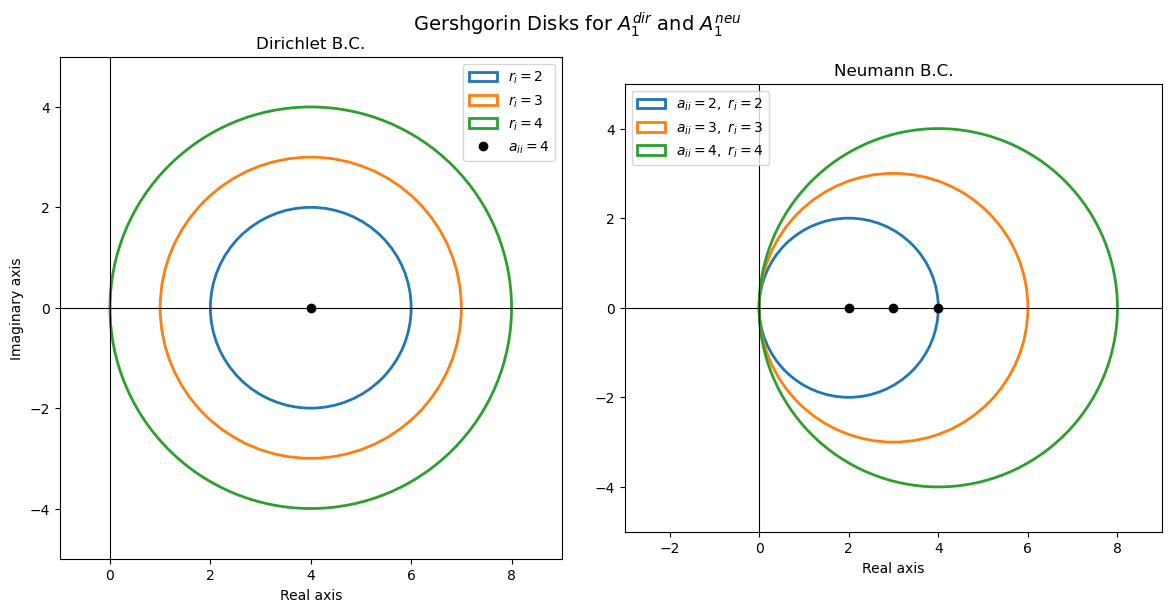

In [36]:
# --- Dirichlet setup ---
center_dir = 4
radii_dir = [2, 3, 4]
colors_dir = ['tab:blue', 'tab:orange', 'tab:green']

# --- Neumann setup ---
# Centers depend on a_ii = {2, 3, 4}, radii equal to those values
centers_neu = [2, 3, 4]
radii_neu = [2, 3, 4]
colors_neu = ['tab:blue', 'tab:orange', 'tab:green']

# --- Create subplots ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# === Dirichlet plot ===
ax = axes[0]
for r, c in zip(radii_dir, colors_dir):
    circle = plt.Circle((center_dir, 0), r, color=c, fill=False, lw=2, label=fr"$r_i={r}$")
    ax.add_patch(circle)

ax.plot(center_dir, 0, 'ko', label=r"$a_{ii}=4$")
ax.axhline(0, color='black', lw=0.8)
ax.axvline(0, color='black', lw=0.8)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1, 9)
ax.set_ylim(-5, 5)
ax.set_title("Dirichlet B.C.")
ax.set_xlabel("Real axis")
ax.set_ylabel("Imaginary axis")
ax.legend()

# === Neumann plot ===
ax = axes[1]
for cen, r, c in zip(centers_neu, radii_neu, colors_neu):
    circle = plt.Circle((cen, 0), r, color=c, fill=False, lw=2, label=fr"$a_{{ii}}={cen},\ r_i={r}$")
    ax.add_patch(circle)

ax.plot(centers_neu, [0]*len(centers_neu), 'ko')
ax.axhline(0, color='black', lw=0.8)
ax.axvline(0, color='black', lw=0.8)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-3, 9)
ax.set_ylim(-5, 5)
ax.set_title("Neumann B.C.")
ax.set_xlabel("Real axis")
ax.legend()

# --- Global figure title ---
fig.suptitle("Gershgorin Disks for $A_1^{dir}$ and $A_1^{neu}$", fontsize=14)
plt.tight_layout()
plt.show()

Now we look at $A_2$. This matrix is the same for both B.C.s For this matrix to be some type of diagonally dominant we need $(I_x)_i^2 \geq |(I_x)_i(I_y)_i|$ and $(I_y)_i^2 \geq |(I_x)_i(I_y)_i|$ for all $i=1,...,mn$. This is only true if $|(I_x)_i|=|(I_x)_i|$, wich is generally not true. However, this does not discard positive (semi-)definiteness.

For any $x\in \mathbb{R}^{2mn}$,

$$
x^T
\begin{bmatrix}
D_{xx} & D_{xy} \\
D_{yx} & D_{yy}
\end{bmatrix}
x
=
\begin{bmatrix}
u^\top & v^\top
\end{bmatrix}
\begin{bmatrix}
D_{xx} & D_{xy} \\
D_{yx} & D_{yy}
\end{bmatrix}
\begin{bmatrix}
u \\[3pt]
v
\end{bmatrix}
=
u^\top D_{xx} u 
+ u^\top D_{xy} v 
+ v^\top D_{yx} u 
+ v^\top D_{yy} v
=
\sum_{i=1}^{mn} (I_x)^2_i u_i^2 + 2 \sum_{i=1}^{mn}(I_x)_i(I_y)_i u_iv_i + \sum_{i=1}^{mn} (I_y)_i^2 v_i^2 = \sum_{i=1}^{mn} \Big( (I_x)_iu_i + (I_y)_i v_i \Big)^2 \geq 0.
$$




Knowing $A_1$ is positive definite and $A_2$ is positive semi-definite we get for any $x\in \mathbb{R}^{2mn}$

$$
x^TAx = x^T(\lambda A_1+A_2)x= \lambda x^TA_1x + x^TA_2x \geq \lambda x^TA_1x > 0.
$$

In conclusion the whole system is positive definite.

## Convergence results

When applying Dirichlet boundary conditions to (5), the resulting system matrix becomes symmetric and positive definite. In this case, the **Gauss-Seidel** method is guaranteed to converge for any initial guess, while the **Conjugate Gradient (CG)** method also converges and is the most efficient choice due to its suitability for symmetric positive definite systems. The **Jacobi** method, on the other hand, is generally much slower and not guaranteed to converge for all choices of parameters. It converges for the pure Laplacian but can fail for the full operator $A = \lambda A_1 + A_2$ if the additional terms in $A_2$ destroy diagonal dominance. In practice, Jacobi convergence depends on the spectral radius of the iteration matrix, and without strict diagonal dominance this condition may not hold.

For Neumann boundary conditions, the Laplacian part $A_1$ is only positive semi-definite, with a constant vector in its nullspace. If the image-dependent term $A_2$ removes this nullspace, the full operator becomes positive definite, and the same convergence properties apply as in the Dirichlet case: both **Gauss-Seidel** and **CG** converge, while **Jacobi** remains conditionally convergent. However, if the constant mode is not removed and the system remains singular, none of the iterative methods are guaranteed to converge. In such cases, one must either regularize the system slightly or constrain the solution space (for instance by enforcing zero mean) to restore uniqueness and ensure convergence.


## Generate test images

In [14]:
n = 2**8
test_case_1 = generate_test_image(n, testcase=1)
test_case_2 = generate_test_image(n, testcase=2)

## Conjugate gradient

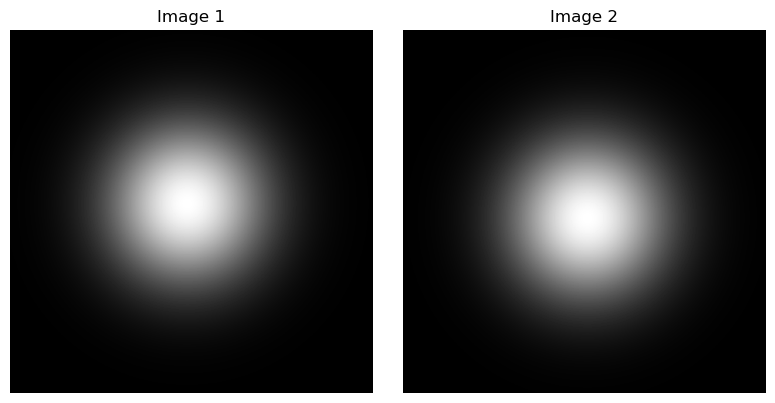

In [15]:

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(test_case_1[0], cmap='gray')
axes[0].set_title("Image 1")
axes[0].axis('off')

axes[1].imshow(test_case_1[1], cmap='gray')
axes[1].set_title("Image 2")
axes[1].axis('off')

plt.tight_layout()
plt.show()

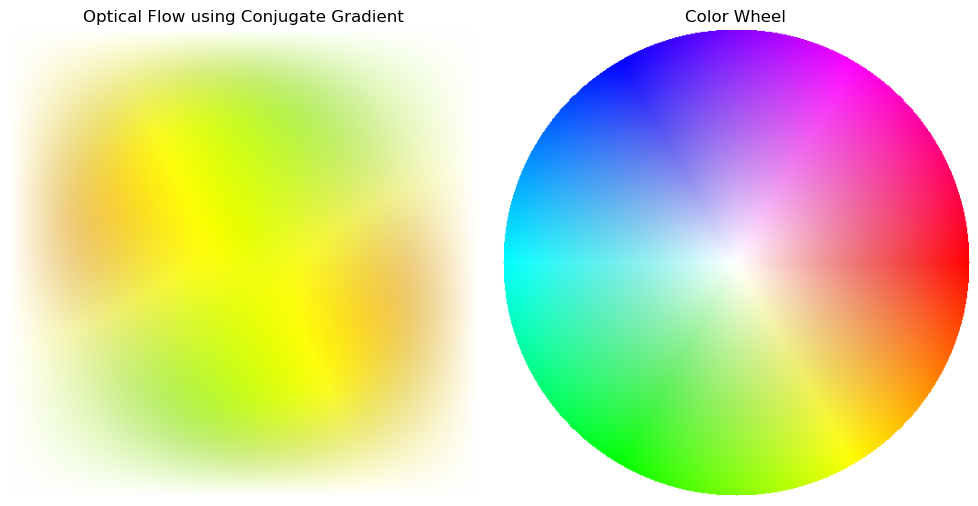

CG converged in 744 iterations with residual norm 1.19e+04


In [16]:

reg = 4**(8-4)

Ix, Iy, It = calculate_image_derivatives(test_case_1[0], test_case_1[1])
rhs_u, rhs_v = get_rhs(Ix, Iy, It)
u0 = np.zeros_like(rhs_u)
v0 = np.zeros_like(rhs_v)

u_cg, v_cg, residuals_cg, max_iter_cg = OF_cg(u0, v0, Ix, Iy, reg, rhs_u, rhs_v, tol=1e-8, maxit=2000)

of_img = mycomputeColor(u_cg, v_cg)
color_wheel = mycolorwheel(n)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left plot: optical flow image
axs[0].imshow(of_img)
axs[0].set_title("Optical Flow using Conjugate Gradient")
axs[0].axis('off')

# Right plot: color wheel
axs[1].imshow(color_wheel)
axs[1].set_title("Color Wheel")
axs[1].axis('off')

plt.tight_layout()
plt.show()

res_cg = residuals_cg[-1]
print(f"CG converged in {max_iter_cg} iterations with residual norm {res_cg:.2e}")

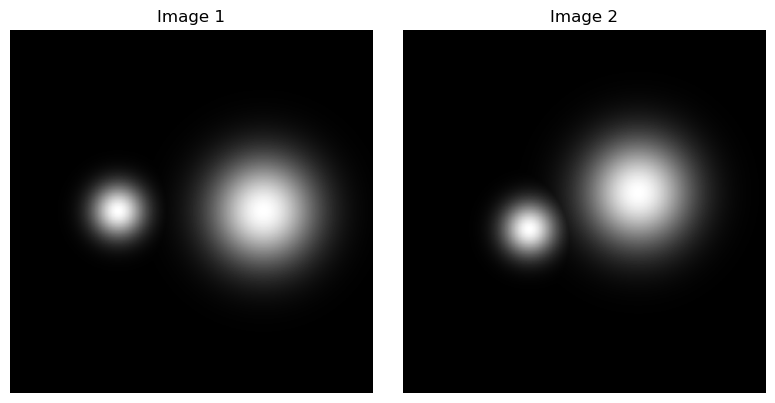

In [17]:
# Plotting below made by LLM
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(test_case_2[0], cmap='gray')
axes[0].set_title("Image 1")
axes[0].axis('off')

axes[1].imshow(test_case_2[1], cmap='gray')
axes[1].set_title("Image 2")
axes[1].axis('off')

plt.tight_layout()
plt.show()

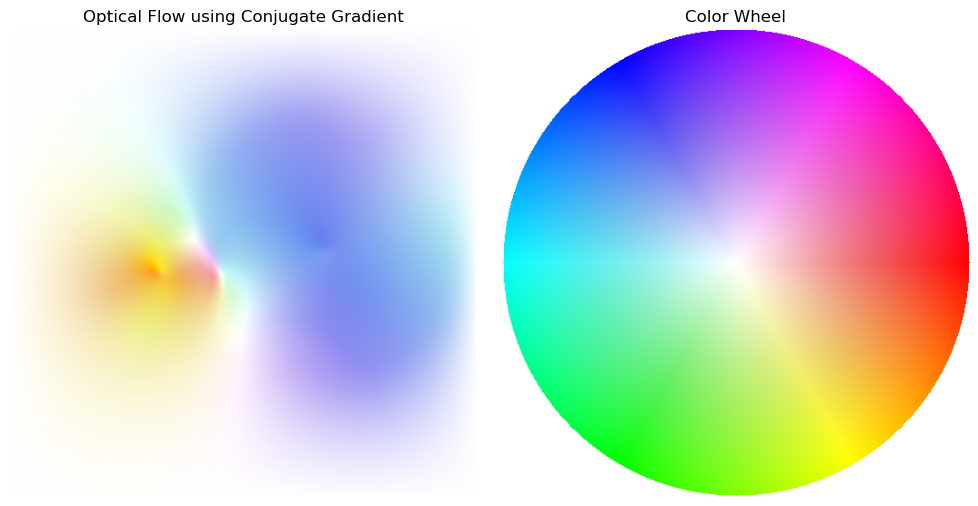

CG converged in 790 iterations with residual norm 4.42e+04


In [ ]:
reg = 4**(6-4)

Ix, Iy, It = calculate_image_derivatives(test_case_2[0], test_case_2[1])
rhs_u, rhs_v = get_rhs(Ix, Iy, It)
u0 = np.zeros_like(rhs_u)
v0 = np.zeros_like(rhs_v)

u_cg, v_cg, residuals_cg, max_iter_cg = OF_cg(u0, v0, Ix, Iy, reg, rhs_u, rhs_v, tol=1e-8, maxit=2000)

of_img = mycomputeColor(u_cg, v_cg)
color_wheel = mycolorwheel(n)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left plot: optical flow image
axs[0].imshow(of_img)
axs[0].set_title("Optical Flow using Conjugate Gradient")
axs[0].axis('off')

# Right plot: color wheel
axs[1].imshow(color_wheel)
axs[1].set_title("Color Wheel")
axs[1].axis('off')

plt.tight_layout()
plt.show()

res_cg = residuals_cg[-1]
print(f"CG converged in {max_iter_cg} iterations with residual norm {res_cg:.2e}")

In [26]:
img_path1 = 'frame10.png'
img_path2 = 'frame11.png'

u_cg, v_cg, res_cg, max_iter_cg = cg_main(img_path1, img_path2, reg=1e-2, tol=1e-8, maxit=2000)

of_img = mycomputeColor(u_cg, v_cg)
plt.imshow(of_img)
plt.title("Optical Flow using Conjugate Gradient")
plt.show()

print(f"CG converged in {max_iter_cg} iterations with residual norm {res_cg:.2e}")

KeyboardInterrupt: 

# Numerical tests

## Conjugate gradient


--- Plotting method=CG, N=256, testcase=1 ---


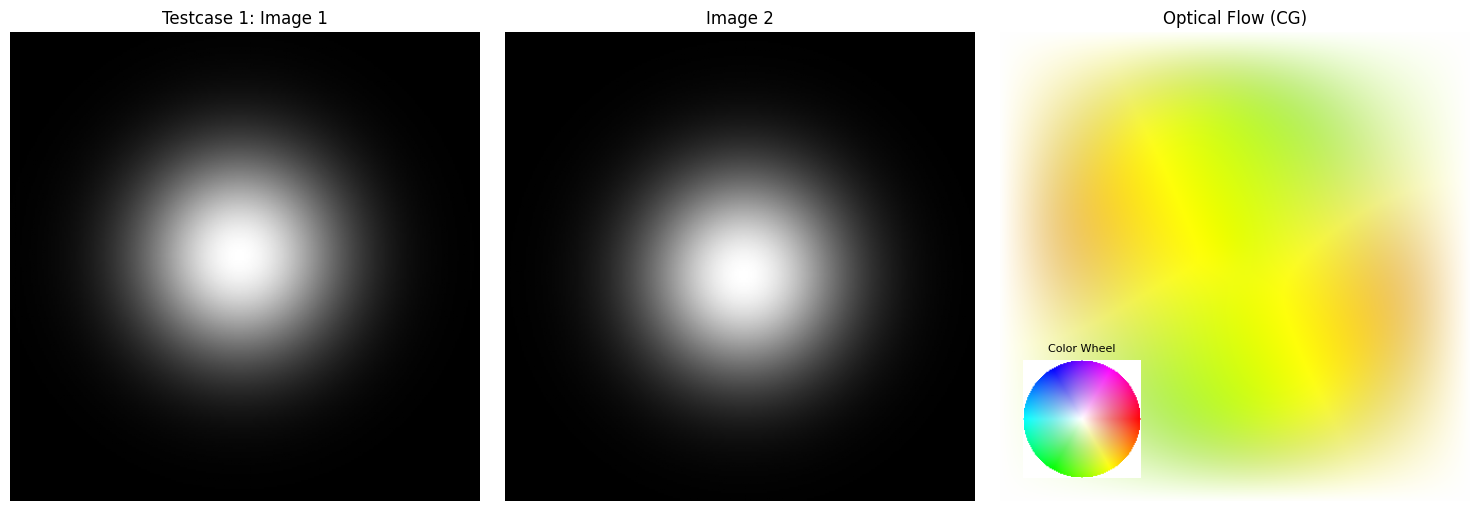

In [3]:
nt.plot_method_solution(N=256, testcase=1, method="CG")

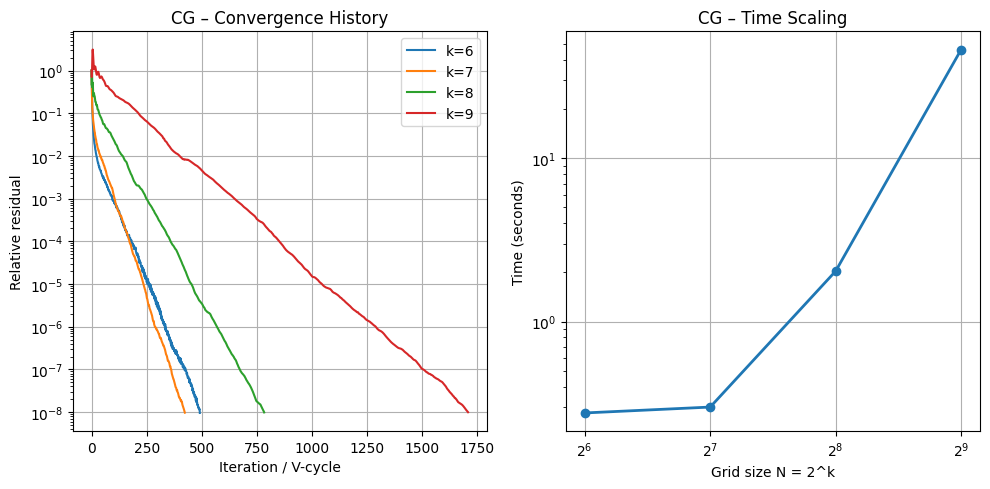

In [8]:
ks = [6,7,8,9]
results_CG = nt.run_single_method("CG", ks, testcase=2)
nt.plot_method_summary(ks, results_CG, method="CG")

The CG method converges for all resolutions $N = 2^k$, $k = 6,\dots,9$, and reaches the required tolerance. The convergence curves for $k = 6,7,8$ are smooth, while the curve for $k = 9$ shows a brief irregularity in the first few iterations. This kind of non-monotonic behaviour can occur while the Krylov space is being constructed and does not indicate instability. After this initial phase, the residual decreases steadily for all grid sizes.

The number of iterations generally increases with $k$. A small exception occurs at $k=7$, where the iteration count is slightly lower than for $k=6$. Such fluctuations are normal, since the effective conditioning of the system depends not only on the grid spacing but also on the structure of the image derivatives at each resolution. The overall trend, however, is clear. Larger grids require more iterations. This matches the theoretical behaviour for elliptic PDE-like problems, where the condition number grows proportionally to $N^2$, leading to an iteration count that increases approximately linearly with $N$.

The computation time grows much faster than the iteration count. Each iteration involves operations on all $N^2$ pixels, so the total time scales roughly like $\text{time} \sim (\text{iterations}) \times N^2.$
This leads to a sharp rise in runtime from $k=6$ to $k=9$, even in cases where the increase in iteration count is modest. Overall, CG remains robust and consistent across all problem sizes, but its computational cost grows rapidly with grid resolution, which makes it less suitable for large images without preconditioning.

## Multigrid V-cycle

In [ ]:
s1_values = [1, 2, 3]
s2_values = [1, 2, 3]
level_values = [2, 3, 4]

# run sweep
mg_sweep_results = nt.run_mg_parameter_sweep(k=7, testcase=2, s1_values=s1_values, s2_values=s2_values, level_values=level_values, tol=1e-8, max_cycles=200)

# print best configs
nt.summarize_mg_sweep(mg_sweep_results)


Best multigrid parameter combinations (sorted by time):
 time [s]  cycles   conv_factor    L   s1   s2
   0.595      14         0.260    4    3    3
   0.662      17         0.326    4    3    2
   0.666      17         0.323    4    2    3
   0.744      21         0.406    4    2    2
   0.770      12         0.209    3    3    3


In [ ]:
levels = [2, 3, 4]
smooth_vals = [1, 2, 3]

results_6 = nt.mg_parameter_sweep(k=6, testcase=2, levels=levels, smooth_vals=smooth_vals, tol=1e-8, max_cycles=200)
Svals_6, rho_mat_6, time_mat_6 = nt.results_to_matrices(results_6, levels, smooth_vals)
nt.plot_mg_heatmaps(levels, Svals_6, rho_mat_6, time_mat_6)

results_7 = nt.mg_parameter_sweep(k=6, testcase=2, levels=levels, smooth_vals=smooth_vals, tol=1e-8, max_cycles=200)
Svals_7, rho_mat_7, time_mat_7 = nt.results_to_matrices(results_7, levels, smooth_vals)
nt.plot_mg_heatmaps(levels, Svals_7, rho_mat_7, time_mat_7)

results = nt.mg_parameter_sweep(k=6, testcase=2, levels=levels, smooth_vals=smooth_vals, tol=1e-8, max_cycles=200)
Svals, rho_mat, time_mat = nt.results_to_matrices(results, levels, smooth_vals)
nt.plot_mg_heatmaps(levels, Svals, rho_mat, time_mat)

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
def extract_pareto_optimal(results):
    """
    Input: list of dicts with keys L, s1, s2, rho, time
    Output: list of Pareto-optimal tuples (time, rho, L, s1, s2)
    """

    # Extract all valid entries
    candidates = []
    for r in results:
        rho = r["rho"]
        t   = r["time"]
        if not (np.isnan(rho) or np.isnan(t)):
            candidates.append((t, rho, r["L"], r["s1"], r["s2"]))

    # Pareto filter
    pareto = []
    for c in candidates:
        tc, rhoc, Lc, s1c, s2c = c
        dominated = False

        for d in candidates:
            td, rhod, Ld, s1d, s2d = d

            # strictly better in both = domination
            if (td < tc) and (rhod < rhoc):
                dominated = True
                break

        if not dominated:
            pareto.append(c)

    # Sort by time then convergence
    pareto = sorted(pareto, key=lambda x: (x[0], x[1]))

    return pareto



def print_pareto_table(pareto):
    """
    Input: list of tuples (time, rho, L, s1, s2)
    """

    print("Pareto-optimal Multigrid Configurations:")
    print(" time[s]    rho      L   s1   s2")
    print("---------------------------------------")

    for (t, rho, L, s1, s2) in pareto:
        print(f" {t:7.3f}   {rho:7.3f}   {L:2d}   {s1:2d}   {s2:2d}")


In [ ]:
pareto = extract_pareto_optimal(levels, Svals_6, rho_mat_6, time_mat_6)
print_pareto_table(pareto)

pareto = extract_pareto_optimal(levels, Svals_7, rho_mat_7, time_mat_7)
print_pareto_table(pareto)

pareto = extract_pareto_optimal(levels, Svals_8, rho_mat_8, time_mat_8)
print_pareto_table(pareto)

Pareto-optimal MG parameter choices:
 time[s]    rho       L   s1=s2 
--------------------------------------
   0.407     0.377     4    6
   0.561     0.307     3    6


In [ ]:
pareto = extract_pareto_optimal(levels, Svals, rho_mat, time_mat)
print_pareto_table(pareto)

Pareto-optimal MG parameter choices:
 time[s]    rho       L   s1=s2 
--------------------------------------
   0.618     0.285     4    6
   0.823     0.236     3    6
   0.937     0.175     2    6


In [10]:
pareto = extract_pareto_optimal(levels, Svals, rho_mat, time_mat)
print_pareto_table(pareto)

Pareto-optimal MG parameter choices:
 time[s]    rho       L   s1=s2 
--------------------------------------
   1.506     0.324     3    6
   1.678     0.253     2    5
   1.694     0.229     2    6


In [2]:
# Step 1: iteration sweep
iteration_data = nt.sweep_over_k_for_iterations(k_values=(6, 7, 8),
    testcase=2,
    levels=(2, 3, 4),
    s1_values=(1, 2, 3),
    s2_values=(1, 2, 3),
    tol=1e-8,
    max_cycles=200)

# Step 2: rank configurations
ranking = nt.rank_by_iteration_trend(iteration_data)

# Step 3: pick finalists
finalists = nt.pick_top_configs(ranking, top_n=3)


=== Running MG sweep for k=6 (size = 64) ===

=== Running MG sweep for k=7 (size = 128) ===

=== Running MG sweep for k=8 (size = 256) ===


In [4]:
print(ranking)

[(inf, inf, inf, (2, 1, 1)), (inf, inf, inf, (2, 1, 2)), (inf, inf, inf, (2, 1, 3)), (inf, inf, inf, (2, 2, 1)), (inf, inf, inf, (2, 2, 2)), (inf, inf, inf, (2, 2, 3)), (inf, inf, inf, (2, 3, 1)), (inf, inf, inf, (2, 3, 2)), (inf, inf, inf, (2, 3, 3)), (inf, inf, inf, (3, 1, 1)), (inf, inf, inf, (3, 1, 2)), (inf, inf, inf, (3, 1, 3)), (inf, inf, inf, (3, 2, 1)), (inf, inf, inf, (3, 2, 2)), (inf, inf, inf, (3, 2, 3)), (inf, inf, inf, (3, 3, 1)), (inf, inf, inf, (3, 3, 2)), (inf, inf, inf, (3, 3, 3)), (inf, inf, inf, (4, 1, 1)), (inf, inf, inf, (4, 1, 2)), (inf, inf, inf, (4, 1, 3)), (inf, inf, inf, (4, 2, 1)), (inf, inf, inf, (4, 2, 2)), (inf, inf, inf, (4, 2, 3)), (inf, inf, inf, (4, 3, 1)), (inf, inf, inf, (4, 3, 2)), (inf, inf, inf, (4, 3, 3))]


### The test

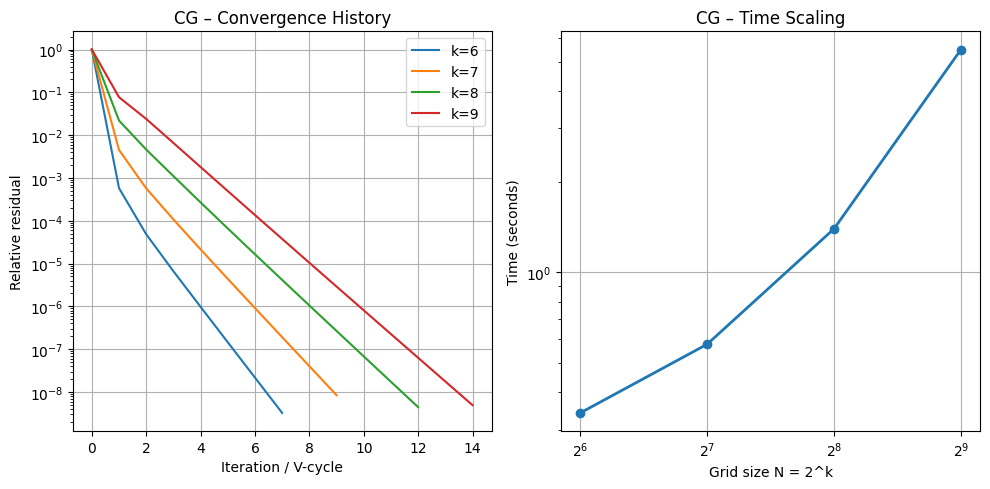

In [5]:
ks = [6,7,8,9]
results_MG = nt.run_single_method("MG", ks, testcase=1, mg_s1=3, mg_s2=3, mg_max_level=3)
nt.plot_method_summary(ks, results_MG, method="CG")

## PCG

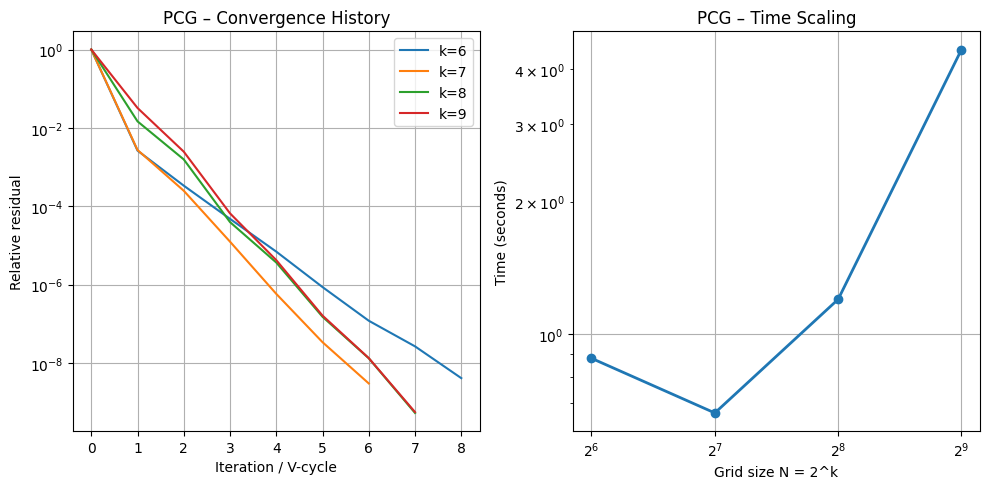

In [2]:
ks = [6,7,8,9]
results_PCG = nt.run_single_method("PCG", ks, testcase=2, mg_s1=4, mg_s2=4, mg_max_level=2)
nt.plot_method_summary(ks, results_PCG, method="PCG")